In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mysql.connector
from dotenv import load_dotenv
import os

# Carrega variáveis do ficheiro .env
load_dotenv()

# Conexão à base de dados
conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)

print("✅ Ligado à base de dados com sucesso.")


✅ Ligado à base de dados com sucesso.


/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2615767488.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


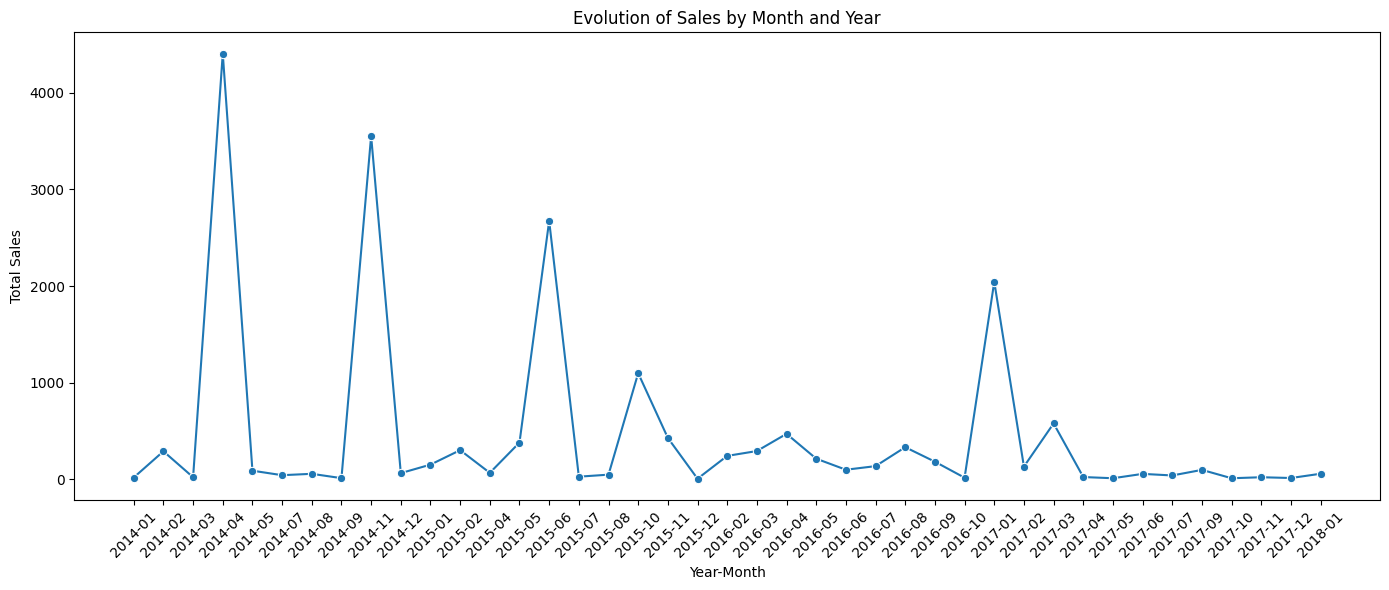

In [3]:
# Cell: Evolution of Sales by Month and Year

query = """
SELECT 
    cm.year_number AS year,
    cm.calendar_month_number AS month_num,
    cm.calendar_month_name AS month_name,
    SUM(o.sales_order) AS total_sales
FROM Orders o
JOIN CalendarMonth cm ON o.order_calendar_id = cm.calendar_month_id
GROUP BY cm.year_number, cm.calendar_month_number, cm.calendar_month_name
ORDER BY cm.year_number, cm.calendar_month_number;
"""

df = pd.read_sql(query, conn)
df["year_month"] = df["year"].astype(str) + "-" + df["month_num"].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x="year_month", y="total_sales", marker="o")
plt.title("Evolution of Sales by Month and Year")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


O gráfico revela a evolução das vendas ao longo do tempo. Picos ou quedas podem indicar sazonalidades ou efeitos de promoções, ajudando na previsão e planejamento estratégico.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/1792547589.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/1792547589.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="region", y="total_profit", palette="viridis")


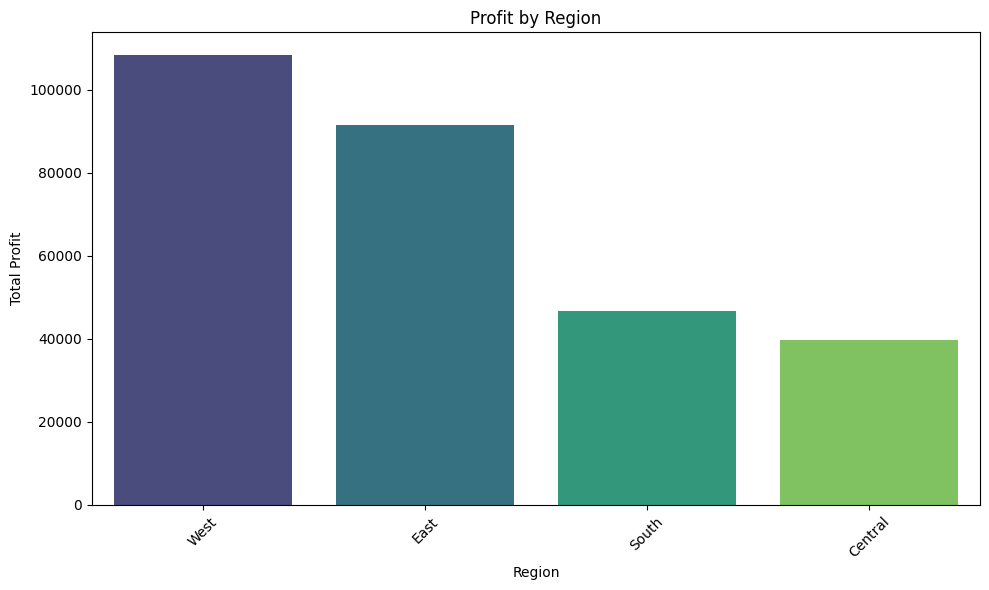

In [4]:
# Cell: Profit by Region
query = """
SELECT 
    r.region_name AS region,
    SUM(o.profit_order) AS total_profit
FROM Orders o
JOIN Location l ON o.location_id = l.location_id
JOIN State s ON l.state_id = s.state_id
JOIN Region r ON s.region_id = r.region_id
GROUP BY r.region_name
ORDER BY total_profit DESC;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="region", y="total_profit", palette="viridis")
plt.title("Profit by Region")
plt.xlabel("Region")
plt.ylabel("Total Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Este gráfico identifica quais regiões geram maior lucro, podendo orientar decisões de investimento, marketing e distribuição de recursos.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/3507929336.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/3507929336.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="total_quantity", y="product_name", palette="magma")


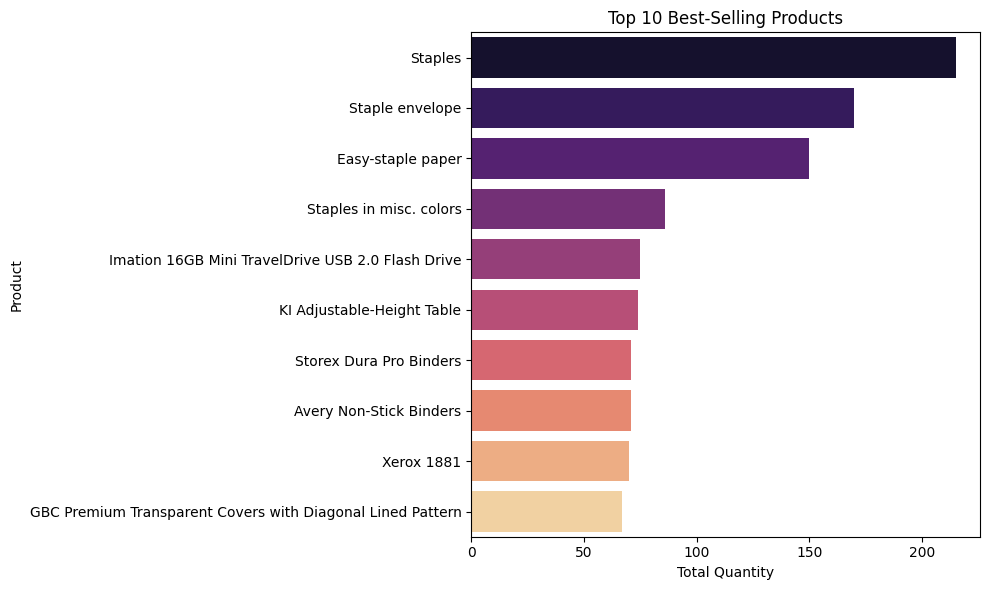

In [5]:
# Cell: Top 10 Best-Selling Products
query = """
SELECT 
    p.product_name,
    SUM(i.quantity) AS total_quantity
FROM Item i
JOIN Product p ON i.product_id = p.product_id
GROUP BY p.product_name
ORDER BY total_quantity DESC
LIMIT 10;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="total_quantity", y="product_name", palette="magma")
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


Visualiza os produtos com maior volume de vendas, o que pode orientar estratégias de estoque, marketing e análise de demanda.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/3457511300.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/3457511300.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="segment", y="total_sales", palette="coolwarm")


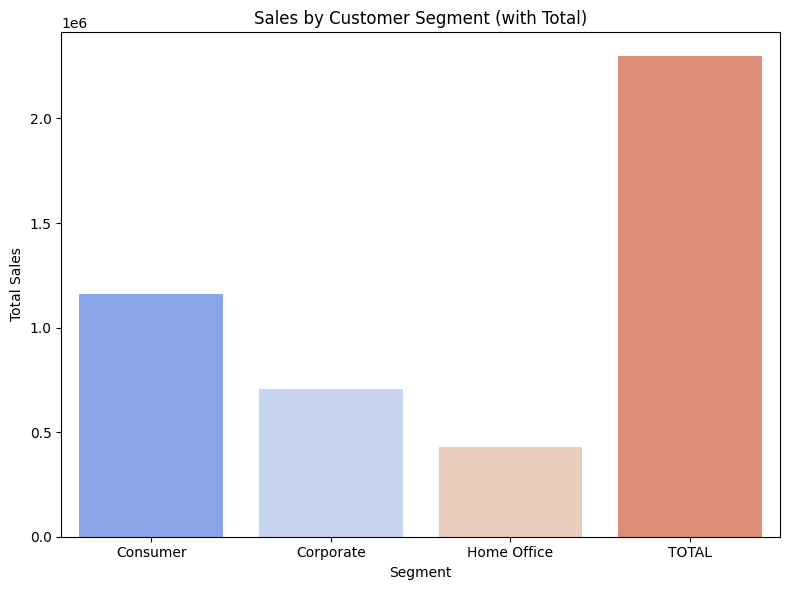

In [6]:
# Cell: Sales by Customer Segment with ROLLUP
query = """
SELECT 
    IF(GROUPING(c.segment), 'TOTAL', c.segment) AS segment,
    SUM(o.sales_order) AS total_sales
FROM Orders o
JOIN Customer c ON o.customer_id = c.customer_id
GROUP BY c.segment WITH ROLLUP;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(8,6))
sns.barplot(data=df, x="segment", y="total_sales", palette="coolwarm")
plt.title("Sales by Customer Segment (with Total)")
plt.xlabel("Segment")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()



A query com ROLLUP mostra as vendas detalhadas por segmento e inclui uma linha de total geral, facilitando a comparação entre segmentos e a visualização do desempenho global.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2844598350.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2844598350.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="ranking", y="total_profit", palette=colors)


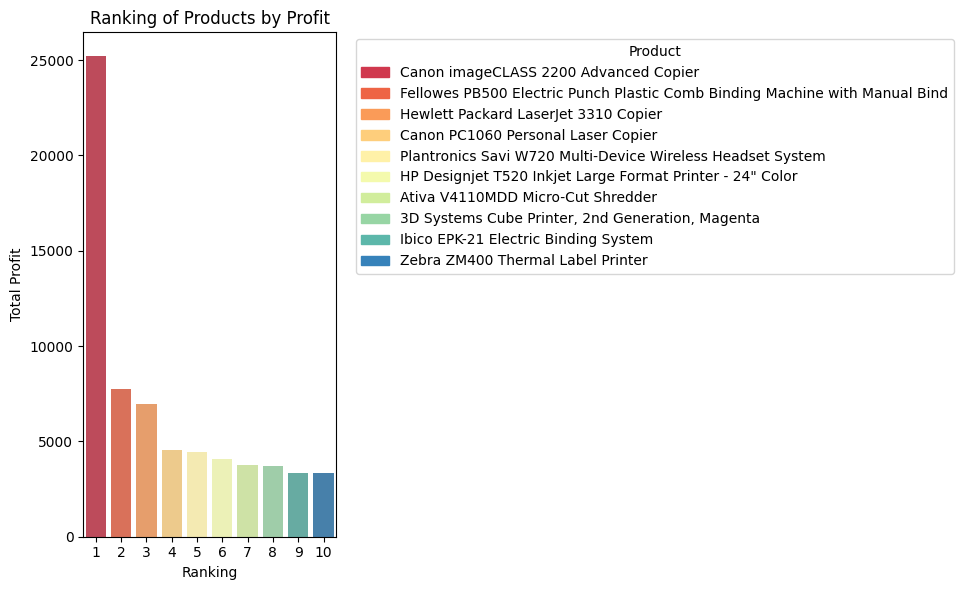

In [25]:
import matplotlib.patches as mpatches
# Cell: Ranking of Products by Profit
query = """
SELECT 
    product_name,
    total_profit,
    RANK() OVER (ORDER BY total_profit DESC) AS ranking
FROM (
    SELECT 
        p.product_name,
        SUM(i.profit) AS total_profit
    FROM Item i
    JOIN Product p ON i.product_id = p.product_id
    GROUP BY p.product_name
) AS sub
ORDER BY ranking
LIMIT 10;
"""

df = pd.read_sql(query, conn)

# Gerar a paleta de cores
colors = sns.color_palette("Spectral", len(df))

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="ranking", y="total_profit", palette=colors)
plt.title("Ranking of Products by Profit")
plt.xlabel("Ranking")
plt.ylabel("Total Profit")

# Criar a legenda
legend_patches = [mpatches.Patch(color=colors[i], label=df['product_name'][i]) for i in range(len(df))]
plt.legend(handles=legend_patches, title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Este gráfico ordena os produtos por lucro, atribuindo um ranking. Permite identificar rapidamente quais produtos são mais rentáveis.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/783058000.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


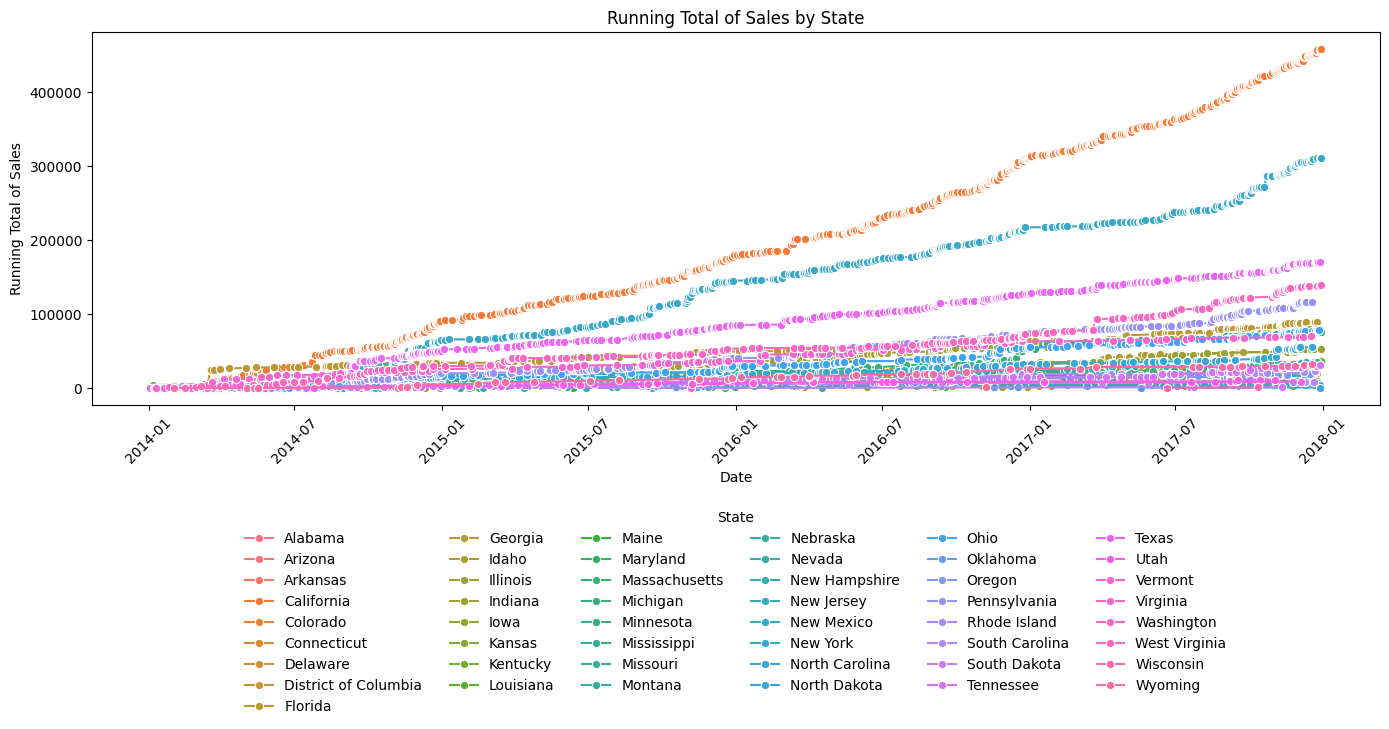

In [26]:
# Cell: Running Total of Sales by State
query = """
SELECT 
    s.state_name,
    c.full_date,
    SUM(o.sales_order) OVER (PARTITION BY s.state_name ORDER BY c.full_date) AS running_total
FROM Orders o
JOIN Location l ON o.location_id = l.location_id
JOIN State s ON l.state_id = s.state_id
JOIN Calendar c ON o.order_calendar_id = c.calendar_id
ORDER BY s.state_name, c.full_date;
"""

df = pd.read_sql(query, conn)
df['full_date'] = pd.to_datetime(df['full_date'])

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x="full_date", y="running_total", hue="state_name", marker="o")
plt.title("Running Total of Sales by State")
plt.xlabel("Date")
plt.ylabel("Running Total of Sales")
plt.xticks(rotation=45)

# Legenda abaixo, horizontal e com colunas automáticas
plt.legend(
    title="State",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=6,  # Podes ajustar esse valor conforme o espaço
    frameon=False
)

plt.tight_layout()
plt.show()


O gráfico mostra, para um estado específico, como as vendas vão se acumulando ao longo do tempo. Essa visualização é útil para compreender tendências e a progressão das receitas por estado.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/3219559694.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df7 = pd.read_sql(query7, conn)


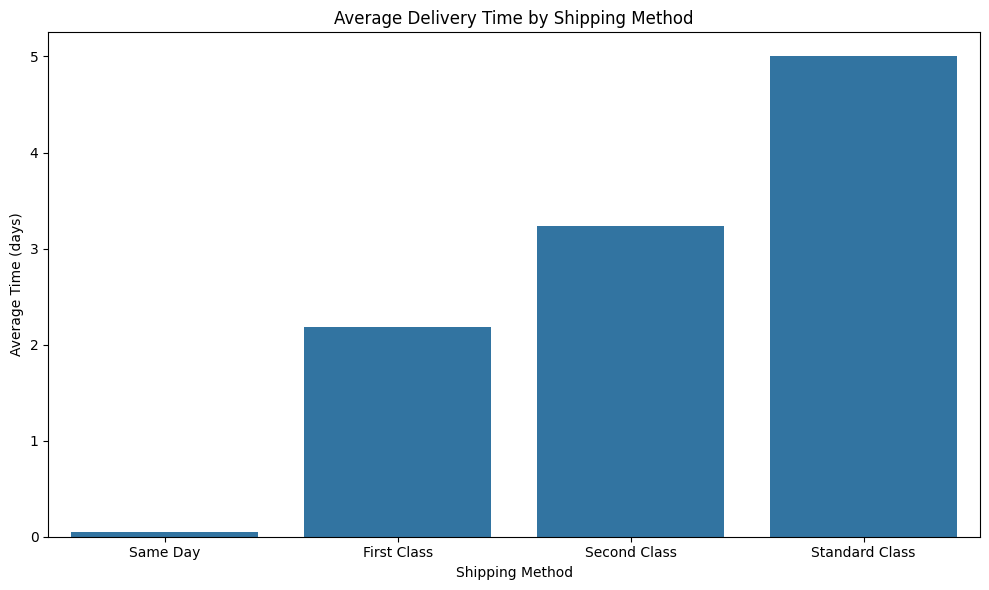

In [9]:
query7 = """
SELECT 
    sh.ship_mode,
    AVG(DATEDIFF(c2.full_date, c1.full_date)) AS average_delivery_time
FROM Orders o
JOIN Shipping sh ON o.shipping_id = sh.shipping_id
JOIN Calendar c1 ON o.order_calendar_id = c1.calendar_id
JOIN Calendar c2 ON o.shipping_calendar_id = c2.calendar_id
GROUP BY sh.ship_mode
ORDER BY average_delivery_time;
"""
df7 = pd.read_sql(query7, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df7, x="ship_mode", y="average_delivery_time")
plt.title("Average Delivery Time by Shipping Method")
plt.xlabel("Shipping Method")
plt.ylabel("Average Time (days)")
plt.tight_layout()
plt.show()



Permite identificar qual o método de envio que apresenta maior ou menor tempo médio entre a encomenda e o envio, ajudando a analisar a eficiência logística.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2439661222.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df8 = pd.read_sql(query8, conn)


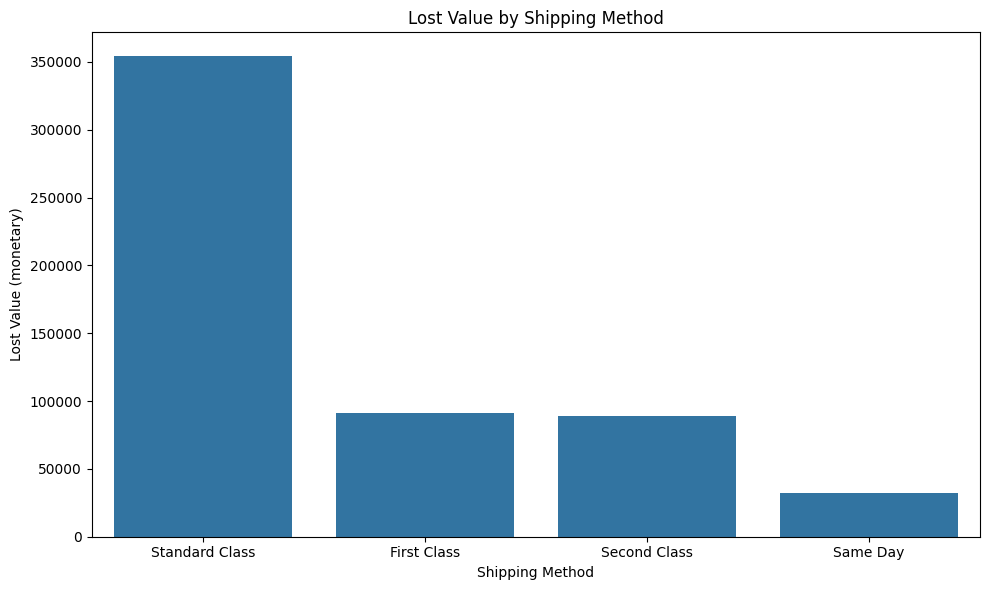

In [10]:
query8 = """
SELECT 
    sh.ship_mode,
    ROUND(SUM(o.lost_value_order), 2) AS lost_value
FROM Orders o
JOIN Shipping sh ON o.shipping_id = sh.shipping_id
GROUP BY sh.ship_mode
ORDER BY lost_value DESC;
"""
df8 = pd.read_sql(query8, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df8, x="ship_mode", y="lost_value")
plt.title("Lost Value by Shipping Method")
plt.xlabel("Shipping Method")
plt.ylabel("Lost Value (monetary)")
plt.tight_layout()
plt.show()



Este gráfico mostra o montante de receita perdido devido aos descontos aplicados, agrupado por método de envio – possibilita identificar se há algum canal que afeta significativamente a rentabilidade.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2823904570.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df9 = pd.read_sql(query9, conn)


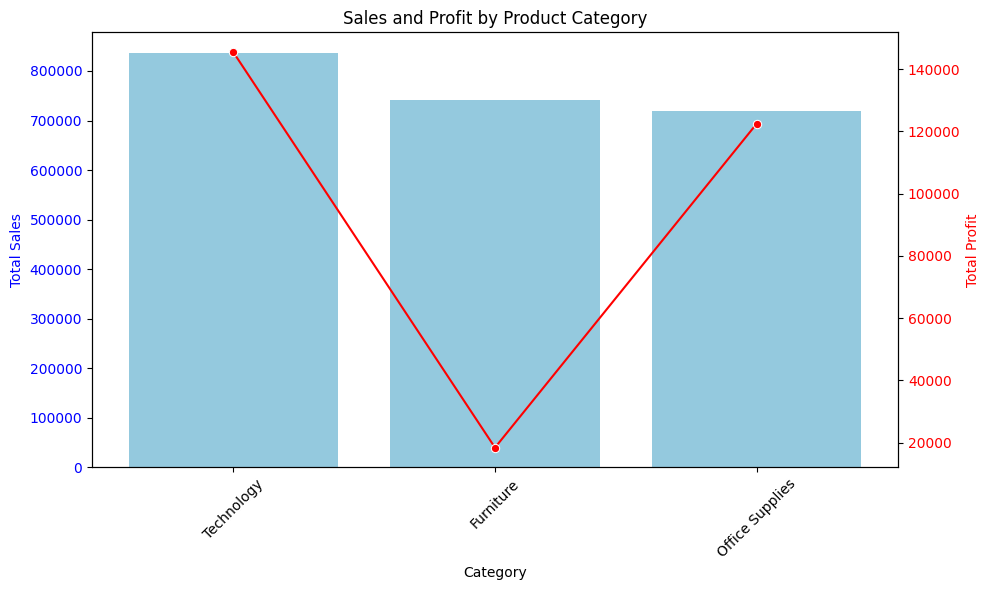

In [11]:
query9 = """
SELECT 
    cat.category_name,
    SUM(i.sales) AS total_sales,
    SUM(i.profit) AS total_profit,
    ROUND(AVG(i.discount), 2) AS average_discount
FROM Item i
JOIN Product p ON i.product_id = p.product_id
JOIN Category cat ON p.category_id = cat.category_id
GROUP BY cat.category_name
ORDER BY total_sales DESC;
"""
df9 = pd.read_sql(query9, conn)

# Dual bar plot for sales and profit
fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(data=df9, x="category_name", y="total_sales", color="skyblue", ax=ax1)
ax1.set_xlabel("Category")
ax1.set_ylabel("Total Sales", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
plt.xticks(rotation=45)

# On top of the same graph, add profit (using a secondary y-axis)
ax2 = ax1.twinx()
sns.lineplot(data=df9, x="category_name", y="total_profit", marker="o", color="red", ax=ax2)
ax2.set_ylabel("Total Profit", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Sales and Profit by Product Category")
plt.tight_layout()
plt.show()


A análise combina duas medidas: o volume de vendas e o lucro por categoria, além de apresentar o desconto médio (que pode ser mostrado em um comentário ou tabela extra). Isso ajuda a identificar quais categorias são mais rentáveis e como as políticas de desconto impactam o desempenho.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/1695416383.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df10 = pd.read_sql(query10, conn)


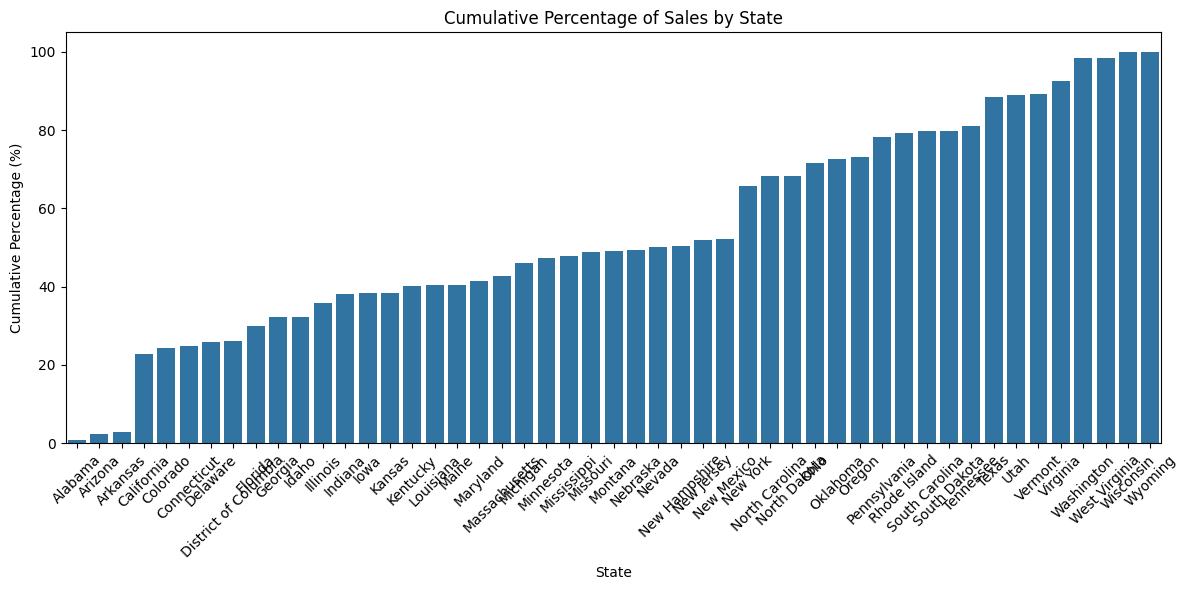

In [12]:
query10 = """
SELECT 
    s.state_name,
    SUM(o.sales_order) AS total_sales,
    SUM(SUM(o.sales_order)) OVER (ORDER BY s.state_name) AS accumulated_sales,
    ROUND(SUM(SUM(o.sales_order)) OVER (ORDER BY s.state_name) / 
          (SELECT SUM(sales_order) FROM Orders) * 100, 2) AS cumulative_percentage
FROM Orders o
JOIN Location l ON o.location_id = l.location_id
JOIN State s ON l.state_id = s.state_id
GROUP BY s.state_name
ORDER BY cumulative_percentage;
"""
df10 = pd.read_sql(query10, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=df10, x="state_name", y="cumulative_percentage")
plt.title("Cumulative Percentage of Sales by State")
plt.xlabel("State")
plt.ylabel("Cumulative Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


O gráfico indica, em ordem crescente de percentual acumulado, como as vendas se distribuem entre os estados, permitindo identificar quais estados concentram a maior parcela das receitas.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/1317696606.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df11 = pd.read_sql(query11, conn)


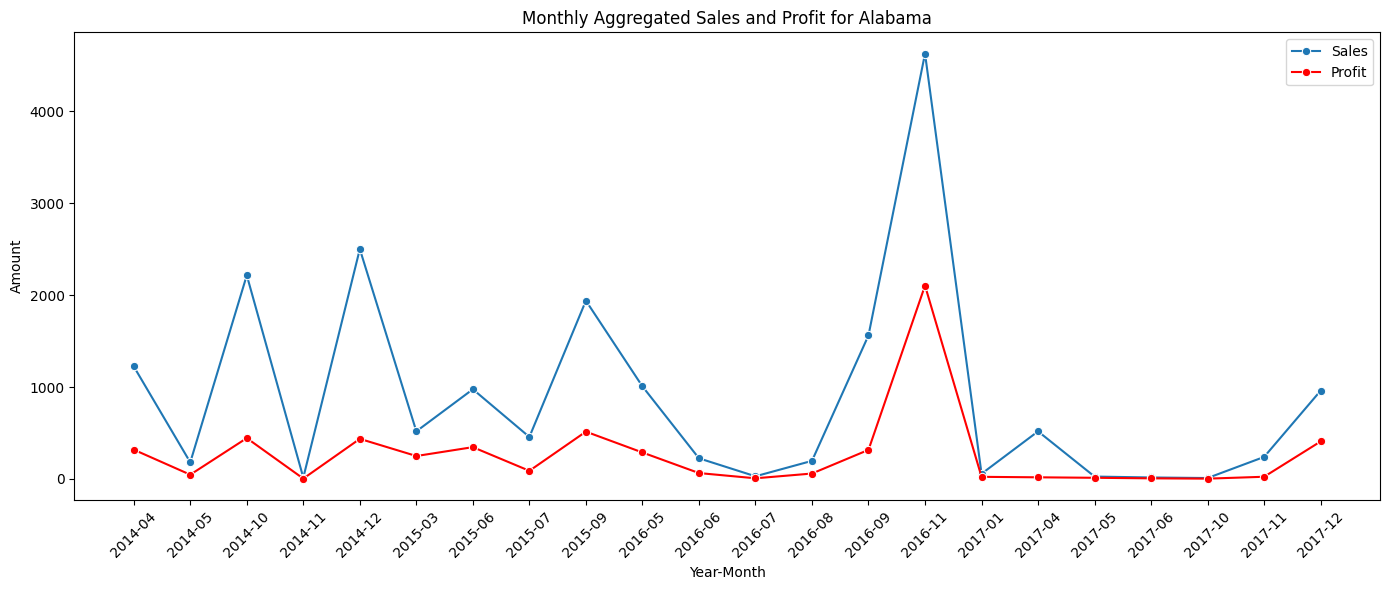

In [13]:
# Query 11: Aggregated Monthly Sales and Profit by State (OrderM fact table)
query11 = """
SELECT 
    s.state_name,
    cm.year_number,
    cm.calendar_month_number,
    cm.calendar_month_name,
    om.sales_month,
    om.profit_month,
    om.quantity_month,
    om.lost_value_month
FROM OrderM om
JOIN CalendarMonth cm ON om.calendar_month_id = cm.calendar_month_id
JOIN State s ON om.state_id = s.state_id
ORDER BY s.state_name, cm.year_number, cm.calendar_month_number;
"""

df11 = pd.read_sql(query11, conn)

# Create a year-month column for easier plotting
df11["year_month"] = df11["year_number"].astype(str) + "-" + df11["calendar_month_number"].astype(str).str.zfill(2)

# For demonstration, filter for a specific state (for example, the first state in the result)
selected_state = df11["state_name"].unique()[0]
df_state = df11[df11["state_name"] == selected_state]

plt.figure(figsize=(14,6))
sns.lineplot(data=df_state, x="year_month", y="sales_month", marker="o", label="Sales")
sns.lineplot(data=df_state, x="year_month", y="profit_month", marker="o", label="Profit", color="red")
plt.title("Monthly Aggregated Sales and Profit for " + selected_state)
plt.xlabel("Year-Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


This visualization shows how, for a given state, monthly sales and profit evolve over time based on the aggregated data in the OrderM fact table. This complements your other queries by demonstrating the use of a higher-level fact table designed for rapid analysis of aggregated order data.

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2761226110.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_qualified = pd.read_sql(query_qualified, conn)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2761226110.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_qual_cat, y="product_name", x="sales", palette="Blues_d")


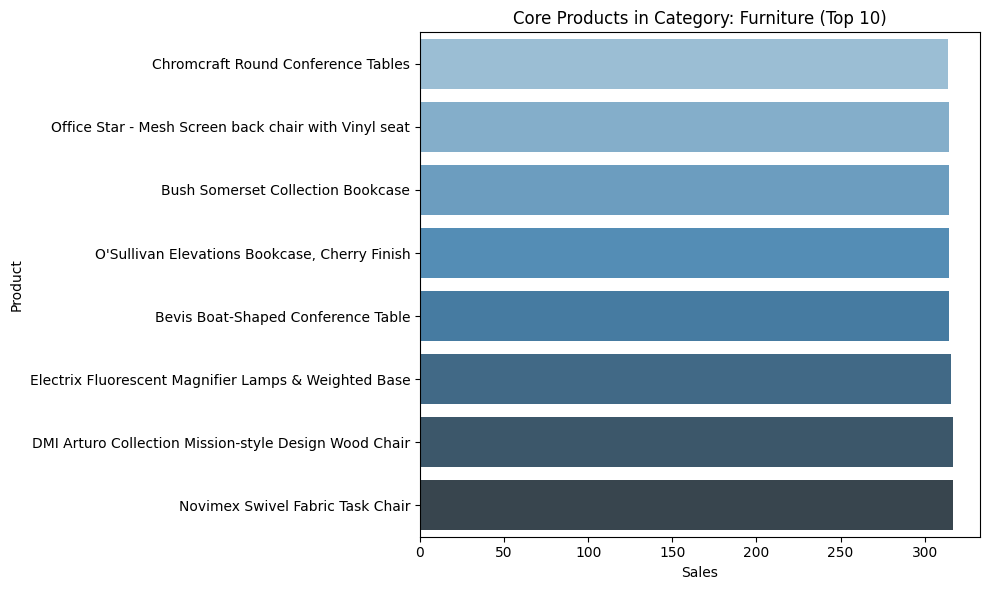

In [19]:
# Cell: Qualified Majority – Core Products in Each Category (Limited to 10 Products)
query_qualified = """
WITH sales_cte AS (
  SELECT 
    cat.category_name,
    p.product_name,
    i.sales,
    SUM(i.sales) OVER (PARTITION BY cat.category_name ORDER BY i.sales DESC ROWS UNBOUNDED PRECEDING) AS running_sales,
    SUM(i.sales) OVER (PARTITION BY cat.category_name) AS total_category_sales
  FROM Item i
  JOIN Product p ON i.product_id = p.product_id
  JOIN Category cat ON p.category_id = cat.category_id
)
SELECT
    category_name,
    product_name,
    sales,
    running_sales,
    total_category_sales
FROM sales_cte
WHERE running_sales - sales < 0.8 * total_category_sales
ORDER BY category_name, running_sales DESC
LIMIT 10;
"""
df_qualified = pd.read_sql(query_qualified, conn)

# For visualization, we can plot for one selected category
selected_cat = df_qualified["category_name"].unique()[0]
df_qual_cat = df_qualified[df_qualified["category_name"] == selected_cat]

plt.figure(figsize=(10,6))
sns.barplot(data=df_qual_cat, y="product_name", x="sales", palette="Blues_d")
plt.title(f"Core Products in Category: {selected_cat} (Top 10)")
plt.xlabel("Sales")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

# Optionally, display the resulting DataFrame
#print(df_qual_cat)


This query identifies, for each product category, the set of products that—when added in descending order of sales—contribute to less than 80% of the category’s total sales. This “qualified majority” analysis is useful to determine the core products driving the bulk of sales.

In [23]:
# Cell: Top Products per Category (using GROUP_CONCAT limited to top 20)
query_concat = """
SELECT
    cat.category_name,
    SUBSTRING_INDEX(
       GROUP_CONCAT(p.product_name ORDER BY i.sales DESC SEPARATOR ', '),
       ', ',
       10
    ) AS top_products,
    SUM(i.sales) AS total_sales
FROM Item i
JOIN Product p ON i.product_id = p.product_id
JOIN Category cat ON p.category_id = cat.category_id
GROUP BY cat.category_name;
"""
df_concat = pd.read_sql(query_concat, conn)

pd.set_option('display.max_colwidth', None)
df_concat


/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_90598/2940178140.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_concat = pd.read_sql(query_concat, conn)


,category_name,top_products,total_sales
0,Furniture,"HON 5400 Series Task Chairs for Big and Tall, Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish, Chromcraft Bull-Nose Wood Oval Conference Tables & Bases, Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish, Sauder Forest Hills Library, Woodland Oak Finish, HON 5400 Series Task Chairs for Big and Tall, Bretford Rectangular Conference Table Tops",741999.98
1,Office Supplies,"GBC Ibimaster 500 Manual ProClick Binding System, Ibico EPK-21 Electric Binding System, High Speed Automatic Electric Letter Opener, Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind, GBC DocuBind P400 Electric Binding System, Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind, High Speed Automatic Electric Letter Opener, Martin Yale Chadless Opener Electric Letter Opener, Ibico EPK-21 Electric Binding System, GBC DocuBind P400 Electric Binding System",719046.99
2,Technology,"Cisco TelePresence System EX90 Videoconferencing Unit, Canon imageCLASS 2200 Advanced Copier, Canon imageCLASS 2200 Advanced Copier, Canon imageCLASS 2200 Advanced Copier, Canon imageCLASS 2200 Advanced Copier, 3D Systems Cube Printer, 2nd Generation, Magenta, HP Designjet T520 Inkjet Large Format Printer - 24"" Color, Canon imageCLASS 2200 Advanced Copier",836154.10


This query uses GROUP_CONCAT to create a list of product names (ordered by sales) for each category along with the total sales. While it’s primarily textual, you can display the result as a table.